## 1. 访问并处理数据集

In [120]:
import os
import hashlib  # 字符串加密功能模块，包含MD5和SHA的算法
import tarfile  # 压缩解压文件
import zipfile  # zip格式编码的压缩和解压缩
import requests

#@save
DATA_HUB = dict()
# 可以将数据集名称的字符串映射到数据集相关的二元组上， 这个二元组包含数据集的url和验证文件完整性的sha-1密钥
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
#  所有类似的数据集都托管在地址为DATA_URL的站点上

download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。

In [121]:
def download(name, cache_dir=os.path.join('..', 'data')): # cache_dir='../data'
    """下载DATA_HUB文件 返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name] # url = DATA_URL + kaggle_pred_house_train
    os.makedirs(cache_dir, exist_ok=True) # 目录存在时不触发异常
    fname = os.path.join(cache_dir, url.split('/')[-1])  # fname = '../data/kaggle_house_train.csv'
    if os.path.exists(fname):
        sha1 = hashlib.sha1() # sha1生成一个160bit的结果，通常用40位的16进制字符串表示
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576) # 每次读2^20Byte=1MB
                if not data: # 如果data为空 not data即True 即break
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash: # 对比加密值，若一致直接返回本地文件名
            return fname
    print(f"正在从{url}下载{fname}...")
    r = requests.get(url, stream=True, verify=True) # stream分段下载 
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname        

In [122]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname) # 返回文件fname的目录名
    data_dir, ext = os.path.splitext(fname)
    # os.path.splitext() 将文件名和扩展名分开
    # os.path.split() 返回文件的路径和文件名
    
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
        
    fp.extractall(base_dir) # 解压压缩包中的所有文件至指定文件夹
    return os.path.join(base_dir, folder) if folder else data_dir # 用于路径拼接文件路径

In [123]:
def download_all():
    """将所有数据集从DATA_HUB下载到缓存目录中"""
    for name in DATA_HUB:
        download(name)

In [124]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [125]:
DATA_HUB['kaggle_house_train'] = (  # url sha1_hash
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [126]:
train_data = pd.read_csv(download('kaggle_house_train')) # 返回值为文件路径名
test_data = pd.read_csv(download('kaggle_house_test'))

In [127]:
print(train_data.shape) # 1460个样本 80个特征和1个label
print(test_data.shape) # 1459个样本 80个features


(1460, 81)
(1459, 80)


In [128]:
# 第一列ID列没用 删除
# 因为为了一次性预处理，所以将训练集和测试集先连接在一起
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
all_features.shape

(2919, 79)

## 2. 数据预处理

先处理数值型特征<br>
标准化-填充缺失值

In [129]:
# 找到数字特征的index 共36个
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 标准化
# df.apply(function, axis=0)默认对df的每一列进行function的操作 常配合lambda表达式
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean()) / (x.std()))
# 特征标准化之后，均值变为0了，所以缺失值也用0填充
all_features[numeric_features] = all_features[numeric_features].fillna(0)

再处理离散型特征，采用独热编码

In [130]:
all_features.shape

(2919, 79)

In [131]:
# get_dummies()可以将各个特征的各个类别都视为一个特征
# dummy_na = T表示视缺失值为有效的特征值
all_features = pd.get_dummies(all_features, dummy_na=True) 
all_features.shape # 特征从79变为331 很快很秀

(2919, 331)

In [132]:
n_train = train_data.shape[0]
# .values将pd转为ndarray 再转为 tensor; 转为tensor时注意将数据类型转换为float32
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['SalePrice'].values.reshape(-1,1),dtype=torch.float32)

## 3. 训练

In [133]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
# 先搞个线性模型，虽然很弱，但是是为了提供一个参考基准，作为基线模型baseline
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1)) # 线性模型
    return net

由于房价预测不可用绝对误差$y-\hat{y}$衡量，用相对误差$\frac{y-\hat{y}}{y}$比较合适<br>
此处用对数的均方根误差$RMSE$
$$
\sqrt{\frac{1}{n} \sum_{i=1}^n(logy_i - log_{\hat{y}_i})^2}
$$

In [134]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1(因为log的定义域有限)
    clipped_preds = torch.clamp(net(features), 1, float('inf')) # clamp将input夹紧到 min和 max之间
    # return np.sqrt(np.sum((np.log(clipped_preds) - np.log(labels)) **2 ) / len(labels))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

训练函数借助Adam优化器 Adam优化器的主要优点在于它对初始学习率不那么敏感

In [135]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size) # 数据迭代器
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # forward
            y_pred = net(X)
            l = loss(y_pred, y)
            # backward
            optimizer.zero_grad()
            l.backward()
            # update
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            
    return train_ls, test_ls

## 4. K折交叉验证 

In [136]:
def get_k_fold_data(k, i, X, y):
    """返回第i折的数据(选择第i个切片作为验证集，剩余部分作为训练集)"""
    assert k > 1 # 最少2折
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # 第j折的索引 若是需要的第i折的话，就给到X_valid，否则给到X_train，其中X_train为None时无法拼接吧
        idx = slice( j * fold_size, (j + 1) * fold_size ) # 返回slice对象(start->end)
        X_part, y_part = X[idx, :], y[idx] # 一行是一个样本
        if j==i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None: # 第一次的j X_train即为X_part
            X_train, y_train = X_part, y_part
        else: # 多次之后的j  相当于是X_train += X_part 
            X_train = torch.cat([X_train, X_part], dim=0) # dimension=0表示按竖着cat(保持行不变)
            y_train = torch.cat([y_train, y_part], dim = 0)
    return X_train, y_train, X_valid, y_valid

In [137]:
train_labels.shape

torch.Size([1460, 1])

In [138]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    """在K折交叉验证中训练K次后，返回训练和验证误差的平均值"""
    train_l_sum, valid_l_sum = 0, 0 
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel = 'epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i+1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum/k, valid_l_sum/k        

折1，训练log rmse0.170731, 验证log rmse0.156301
折2，训练log rmse0.162513, 验证log rmse0.190029
折3，训练log rmse0.163865, 验证log rmse0.168141
折4，训练log rmse0.167957, 验证log rmse0.154306
折5，训练log rmse0.162754, 验证log rmse0.182974
5-折验证: 平均训练log rmse: 0.165564, 平均验证log rmse: 0.170350


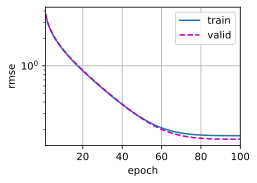

In [139]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')